In [449]:
import numpy as np

class KalmanFilter(object):
    A = None   # linear recursion coeficient
    C = None   # state to measurement scale factor
    P = None   # prediction error
    G = None   # recursion gain
    R = None   # sensor RMS error - diagonal and size depends on the number of measurements
    X = None   # estimated state
    Z = None   # measured state
    Q = None   # prediction covariance - diagonal and size depends on the number of states
    B = None   # system error scaling
    U = None   # bias, offset, system error

    def __init__(self):
        # x_k = A @ x_k-1 + B @ u_k
        self.A = None   # linear recursion coeficient
        self.P = None   # prediction error
        self.G = None   # recursion gain
        self.R = None   # sensor RMS error
        self.X = None   # estimated state
        self.Z = None   # measured state
        self.C = None   # scale factor
        self.Q = None   # prediction covariance (similar to R in measurement)
        self.B = None   # system error scaling
        self.U = None   # bias, offset, system error

    def _predict(self):
        self.X = self.A @ np.nan_to_num(self.X) + self.B @ np.nan_to_num(self.U) + self.X - self.X  # the last X-X is to handle the NaN
        self.P = self.A @ self.P @ self.A.T + self.Q

    @classmethod
    def _initial_measurement(cls, measurement):
        return measurement
    
    @classmethod
    def _foo_measurement(cls, measurement):
        # if non-linear function Extended Kalman Filter has to be used !
        return measurement
        
    def update(self, measurement):
        if (self.X is None):
            self.X = self._initial_measurement(measurement)
            self.U = self._foo_measurement(measurement) - self.X
            return self.X
        self._predict()
        self.Z = self.C @ np.nan_to_num(self._foo_measurement(measurement)) + self._foo_measurement(measurement)-self._foo_measurement(measurement)
        self.U = self.Z - self.X
        self.G = self.P @ self.C.T @ np.linalg.inv(self.C @ self.P @self.C.T + self.R)
        self.G = np.nan_to_num(self.G + self.Z.T - self.Z.T)   # this may be not good, probably not first column but the diagonal should be preserved if NaN
        self.X = self.X + self.G @ (np.nan_to_num(self.Z) - self.C @ np.nan_to_num(self.X))
        self.P = (np.identity(np.shape(self.C)[1]) - self.G @ self.C) @ self.P
        return self.X


class Bpm280Kalman(KalmanFilter):

    @classmethod
    def height(cls, pressure):
        """ hb = Ts/kT * [(pb/ps)^(R*kT/g0) - 1] + hs
            ps, Ts, hs = reference surface pressure and temperature in geodetic height
            R = 287,1 - gas constant
            kT = 6.5*10-3 - temperature gradient
            g0 = 9.80665
            For stand-alone barometry:
            ps = 101.325 kPa
            Ts = 288.15 K
            then hb-hs is orhometric height up to 10.769km
        """
        return 44330.7692307692 * ( 1 - np.power(pressure/1013.25, 0.1902949572))

    @classmethod
    def _initial_measurement(cls, measurement):
        return np.matrix(cls.height(measurement))
    
    @classmethod
    def _foo_measurement(cls, measurement):
        return np.matrix(cls.height(measurement))
    
    def __init__(self):
        self.A = np.matrix([[1.0]])
        self.P = np.matrix([[0.5]])
        self.R = np.matrix([[0.12]])
        self.C = np.matrix([[1.0]])
        self.Q = np.matrix([[0.001]])  # smaller number = smoother result
        self.B = np.matrix([[0.0]])

    
class BpmGPSFusionKalmanFilter(KalmanFilter):
    """ Assumes the barometer state is converted to altitude. No raw pressure. """
    def __init__(self):
        self.A = np.matrix([[1.0, 0.0], [0.0, 1.0]])
        self.C = np.matrix([[1.0, 0.0], [0.0, 1.0]])
        self.R = np.matrix([[1.0, 0.0], [0.0, 10.0]])   # 0.12 hPa or 1m, 8m for GPS
        self.P = np.matrix([[0.5, 0.0], [0.0, 0.5]])
        self.Q = np.matrix([[0.001]])  # smaller number = smoother result
        self.B = np.matrix([[0.0, 0.0], [0.0, 0.0]])
                
    @classmethod
    def _initial_measurement(cls, measurement):
        return measurement
        return measurement[[0]]
        
    def _foo_measurement(self, measurement):
        #return measurement
        return measurement[[1]]
        # replace NaN in measurement with values from X
        m = measurement
        ix = np.where(np.isnan(m))
        m[ix]=self.X[ix]
        return m

    #def update(self, measurement):
        """ For a missing measurement, just use the last state estimate as a measurement 
            but set the covariance matrix of the measurement to essentially infinity. 
            (If the system uses inverse covariance just set the values to zero.) This would 
            cause a Kalman filter to essentially ignore the new measurement since the ratio 
            of the variance of the prediction to the measurement is zero. The result will be 
            a new prediction that maintains velocity/acceleration but whose variance will grow 
            according to the process noise.
        """        
        
class BpmGpsFusionKF2(KalmanFilter):
    """ Assumes the barometer state is converted to altitude. No raw pressure. """
        # self.U - system error should be drived by the GPS measurement

    def __init__(self):
        self.A = np.matrix([[1.0]])
        self.P = np.matrix([[0.5]])
        self.R = np.matrix([[1.0]])
        self.C = np.matrix([[1.0]])
        self.Q = np.matrix([[0.001]])  # smaller number = smoother result
        self.B = np.matrix([[0.0]]) # maybe use the num of satelites to scale the bias in U
                
    @classmethod
    def _initial_measurement(cls, measurement):
        return measurement[[[0],[0]]]
        
    def _foo_measurement(self, measurement):
        return measurement[[[1],[0]]]


In [380]:
import numpy as np
import pandas as pd


in_file = "/Users/dorsic/Downloads/imu/Track2 - Dlhe diely-Palisady/I1569784642.csv"
pin_file = "/Users/dorsic/Downloads/imu/Track2 - Dlhe diely-Palisady/P1569784646.csv"
gps_nmea = "/Users/dorsic/Downloads/imu/Track2 - Dlhe diely-Palisady/G1569784640.nmea"
align = (101.2205, 54, 0.005) # 296169 -> 2872; 39676->338

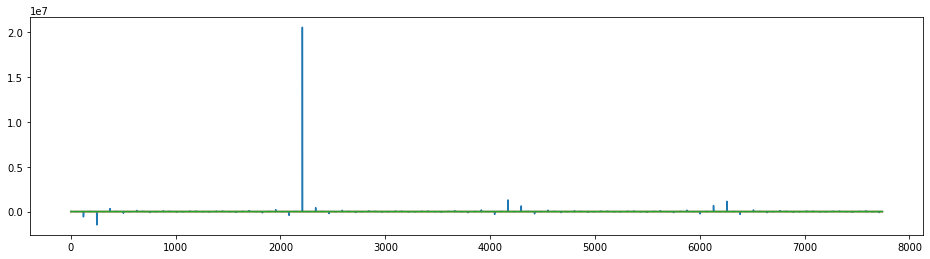

In [257]:
kalman_fuser = BpmGPSFusionKalmanFilter()
kalman_fuser.update(np.matrix([[200],[300]]))
kalman_fuser.update(np.matrix([[210],[330]]))


meas['alt'] = meas.apply(lambda x: kalman_fuser.update( np.matrix([[x[2]], [x[4]]]) )[0,0], axis=1)
plt.figure(figsize=(16,4))
plt.plot(meas[['alt', 'b_alt', 'g_alt']])

In [381]:
data = pd.read_csv(pin_file, sep="\t", names=["ts", "t", "p"], skiprows=100, skipfooter=1, engine='python')

kf = Bpm280Kalman()
kfd = data.apply(lambda x: kf.update(np.matrix([[x[2]]]))[0,0], axis=1)
kfd.head()
data['kf'] = kfd

In [382]:
np.shape(data)  #min 3422
data.head()

,ts,t,p,kf
0,1.569785e+09,12.0405,986.8204,222.403409
1,1.569785e+09,12.0430,986.8311,222.329985
2,1.569785e+09,12.0455,986.8385,222.293822
3,1.569785e+09,12.0480,986.8476,222.255606
4,1.569785e+09,12.0480,986.8492,222.231931


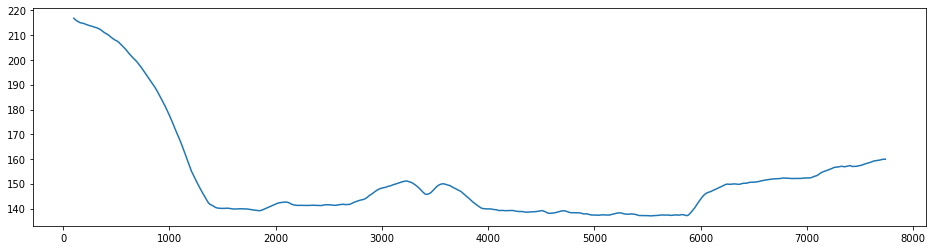

In [383]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
#plt.plot(data[['kf']][0:7743])
plt.plot(data[['kf']][100:7740])

In [261]:
nmea_data = []
with open(gps_nmea, "r") as f:
    for line in f:
        if "$GPGGA" in line:
            vals = line.split(",")
            ts = vals[0].split(" ")[0]
            nmea_data.append((float(ts), float(vals[9]), float(vals[11]), float(vals[8]), int(vals[7])))
gps = pd.DataFrame.from_records(nmea_data, columns=['ts', 'alt', 'geoid_height', 'hdop', 'sat'])

In [262]:
gps.style.format({'ts': '{:0<4.0f}'})

,ts,alt,geoid_height,hdop,sat
0,1569784654,225.94,42.862,0.92,13
1,1569784655,225.44,42.862,0.82,13
2,1569784656,224.19,42.862,0.82,14
3,1569784657,222.8,42.862,0.77,14
4,1569784658,221.92,42.862,0.77,13
5,1569784659,220.74,42.862,0.87,12
6,1569784660,220.04,42.862,0.94,13
7,1569784661,219.21,42.861,0.87,13
8,1569784662,219.01,42.861,0.87,13
9,1569784663,219.12,42.861,0.87,13


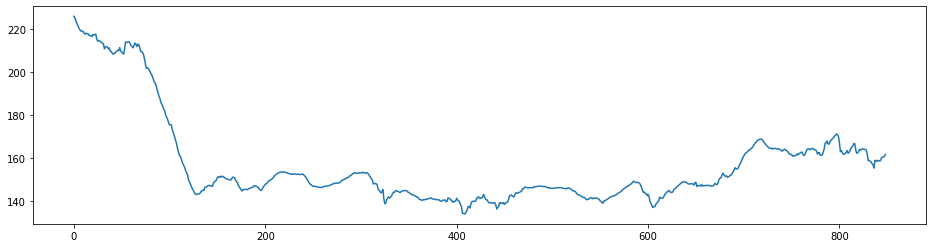

In [263]:
plt.figure(figsize=(16,4))
plt.plot(gps[['alt']])

In [443]:
meas = data[['ts', 'p', 'kf']]
meas['b_alt'] = meas.apply(lambda x: Bpm280Kalman.height(x[1]), axis=1)
meas['g_alt'] = np.NaN
meas['g_sat'] = np.NaN
gidx = 0
for idx, row in meas.iterrows():
    if row['ts'] >= gps.iloc[gidx,0]:
        gidx = gidx + 1
    row['g_alt'] = gps.iloc[gidx, 1]
    row['g_sat'] = gps.iloc[gidx, 4]

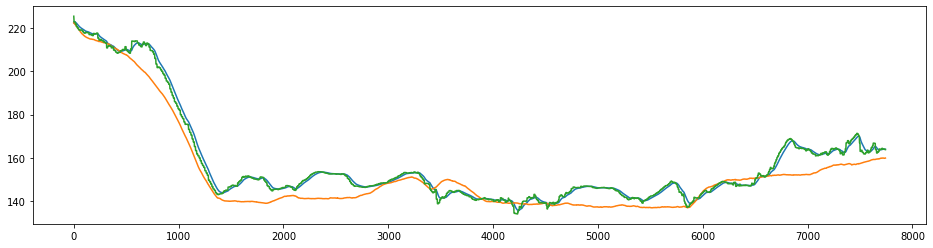

In [450]:
kalman_fuser = BpmGpsFusionKF2()
meas['alt'] = meas.apply(lambda x: kalman_fuser.update( np.matrix([[x[3]], [x[4]]]) )[0,0], axis=1)
plt.figure(figsize=(16,4))
plt.plot(meas[['alt', 'b_alt', 'g_alt']])

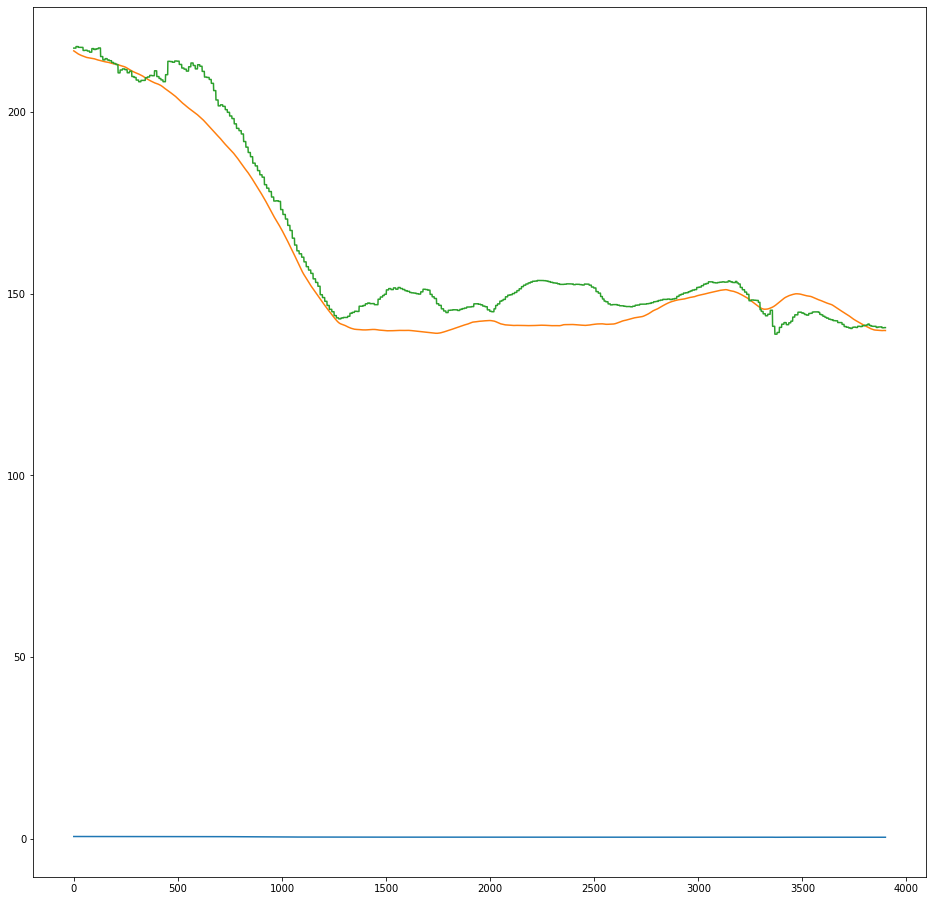

In [448]:
plt.figure(figsize=(16,16))
plt.plot(np.nan_to_num(meas[['alt', 'kf', 'g_alt']][100:4000]))   # blue, orange, green

In [433]:
m = np.matrix([[2], [3]])
print(m[[1]])
#print(m[[1, 0]])

[[3]]


In [412]:
kf = BpmGpsFusionKF2()
m = np.matrix([[meas.iloc[0,3]], [meas.iloc[0,4]]])
kf.update(m)
m = np.matrix([[meas.iloc[1,3]], [meas.iloc[1,4]]])
kf.update(m)
m = np.matrix([[meas.iloc[2,3]], [meas.iloc[2,4]]])
kf.update(m)
#kf._predict()
print(kf.X)
print(kf.U)

#kf.Z = kf.C @ np.nan_to_num(kf._foo_measurement(m)) + m-m
#        self.U = self.Z - self.X
#        self.G = self.P @ self.C.T @ np.linalg.inv(self.C @ self.P @self.C.T + self.R)
#        self.G = np.nan_to_num(self.G + self.Z.T - self.Z.T)   # this may be not good, probably not first column but the diagonal should be preserved if NaN
#        self.X = self.X + self.G @ (np.nan_to_num(self.Z) - self.C @ np.nan_to_num(self.X))
#        self.P = (np.identity(np.shape(self.C)[1]) - self.G @ self.C) @ self.P


          

[[222.94963734]]
[[-0.19973255]]
